In [1]:
import json
import numpy as np
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt

from csc.utils import *
from csc.atoms import *
from csc.workbench import *
from csc.dictionary import *

# Atom parameters
bmin = 0.005
bmax = 0.60
b_step = 0.005
b_values = np.arange(bmin, bmax, b_step)

ymin = 0.01
ymax = 0.034
y_step = 0.002
y_values = np.arange(ymin, ymax, y_step)

s_values = [1]

dictionary = ZSDictionary.from_values(b_values, y_values, s_values)
print('The dictionary has {} different atoms'.format(len(dictionary)))

The dictionary has 1428 different atoms


### Workbench initialization with a database path

In [2]:
batchSize = 200
path_to_signals_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\data_signals_{batchSize}.json'
path_to_omp_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\data_omp_{batchSize}.json'

workbench = CSCWorkbench(path_to_signals_db)
workbench.load_data()
workbench.set_dictionary(dictionary)

In [3]:

metrics_at_step1 = workbench.sortByPositionErrorAtStep(path_to_omp_db, 1, ascending=False)
print(Counter([snr for snr in metrics_at_step1['snr']]))

Counter({15: 600, 10: 600, 0: 600, 5: 600, -5: 600})


In [4]:
metrics_at_step1 = metrics_at_step1.loc[metrics_at_step1['snr'] == 10]
print(metrics_at_step1.head(3))
ids = [id for id in metrics_at_step1.head(3)['id']]
#workbench.plotComparison(db_path=path_to_omp_db, ids=ids)

        id  snr  sparsity  pos_err  abs_pos_err  algo_step
8332  2133   10         4     -499          499          1
7428  1876   10         3     -403          403          1
9590  2398   10         5     -323          323          1


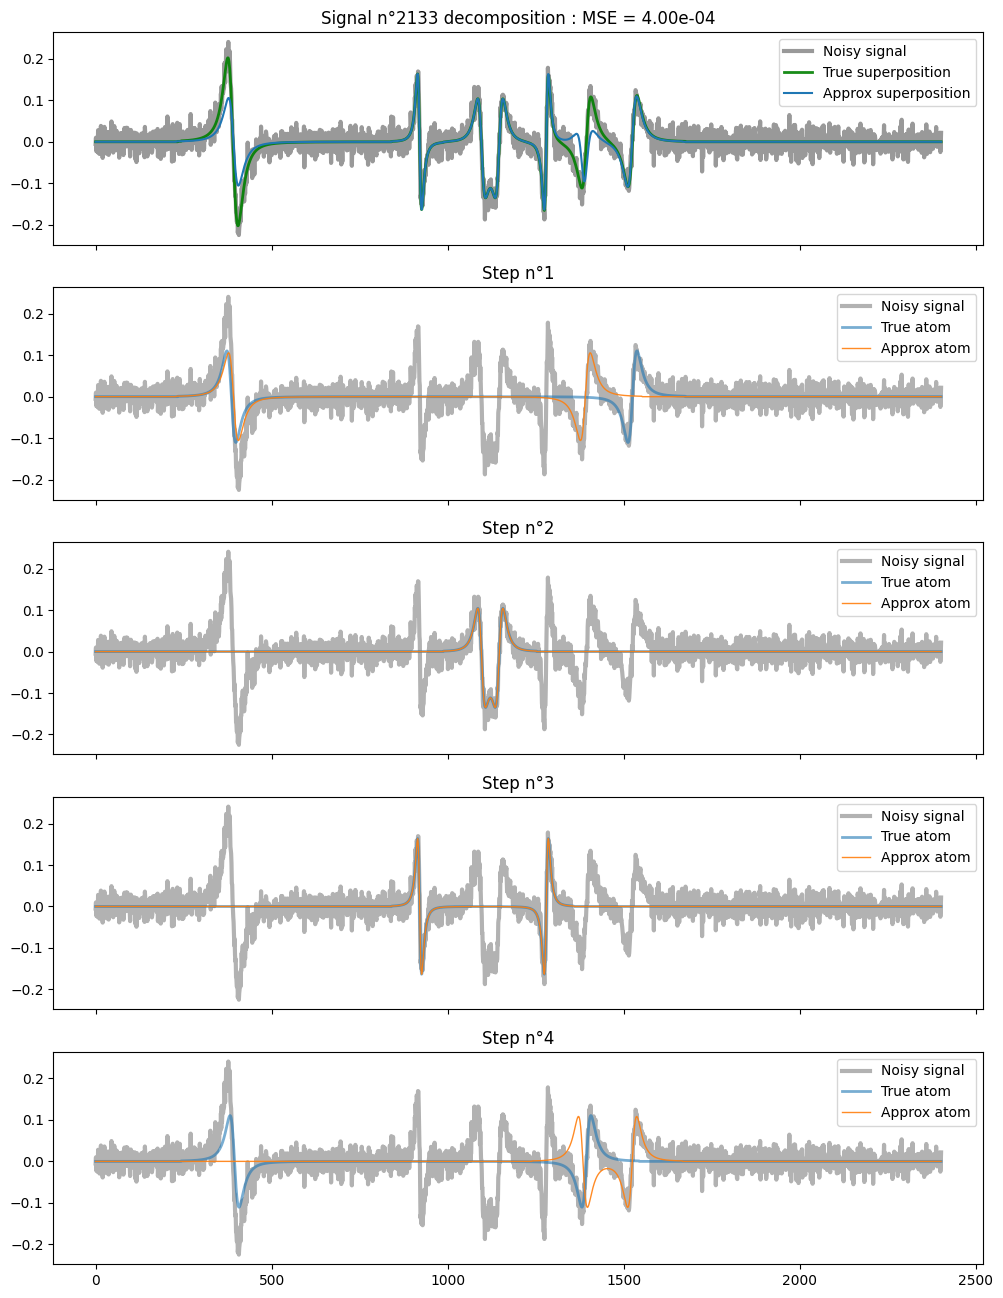

In [5]:
workbench.plotStepDecomposition(db_path=path_to_omp_db, id=ids[0])

In [17]:
signal_dict = workbench.signalDictFromId(id=ids[0])
atoms = signal_dict['atoms']
for atom in atoms:
    print('ZS-ATOM at x={}'.format(atom['x']))
    print('b = {:.3f}'.format(atom['b']))
    print('y = {:.3f}'.format(atom['y']))
    print('s = {:.2e}'.format(atom['s']))
    print('')   

signal_length = len(signal_dict['signal'])


ZS-ATOM at x=154
b = 0.570
y = 0.022
s = 4.12e-05

ZS-ATOM at x=320
b = 0.025
y = 0.018
s = 2.79e-05

ZS-ATOM at x=299
b = 0.180
y = 0.010
s = 1.26e-05

ZS-ATOM at x=93
b = 0.500
y = 0.022
s = 4.12e-05



In [18]:
with open(path_to_omp_db, 'r') as file:
    omp_db = json.load(file)
    signals = omp_db['omp']
    omp_dict = next((item for item in signals if item["id"] == ids[0]), None)
    atoms = omp_dict['atoms']

for atom in atoms:
    print('ZS-ATOM at x={}'.format(atom['x']))
    print('b = {:.3f}'.format(atom['b']))
    print('y = {:.3f}'.format(atom['y']))
    print('s = {:.2e}'.format(atom['s']))
    print('')  

ZS-ATOM at x=90
b = 0.500
y = 0.024
s = 4.69e-05

ZS-ATOM at x=320
b = 0.025
y = 0.018
s = 2.79e-05

ZS-ATOM at x=299
b = 0.180
y = 0.010
s = 1.26e-05

ZS-ATOM at x=653
b = 0.070
y = 0.022
s = 4.07e-05



In [19]:
zs_atom0 = dictionary.getAtomFromParams(atoms[0]['b'], atoms[0]['y'], atoms[0]['s'])
zs_atom0_pos = atoms[0]['x']
print(zs_atom0_pos)

90


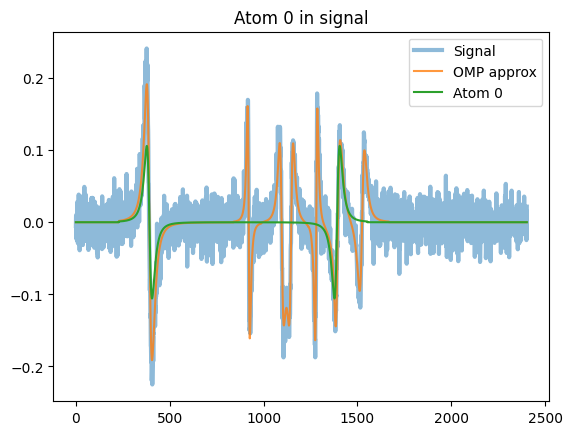

In [23]:

plt.plot(signal_dict['signal'], alpha=0.5, label='Signal', lw=3)
plt.plot(omp_dict['approx'], alpha=0.8, label='OMP approx')
plt.plot(zs_atom0.getAtomInSignal(signal_length, zs_atom0_pos), label='Atom 0')
plt.title('Atom 0 in signal')
plt.legend()
plt.show()

In [76]:
nb_atoms = len(dictionary.getAtoms())
nb_valid_offset = signal_length - dictionary.getAtomsLength() + 1

# Activation mask parameters 
nb_activations = nb_valid_offset * nb_atoms
activation_mask = np.zeros((nb_activations,), dtype=np.float64)

nb_corr = 500
# Compute the correlations
all_corr = dictionary.computeCorrelations(signal_dict['signal'])
max_corr_idx = all_corr.argpartition(-nb_corr, axis=None)[-nb_corr:]
max_corr_idx_sorted = max_corr_idx[all_corr.flatten()[max_corr_idx].argsort()[::-1]]
max_corr_sorted =  all_corr.flatten()[max_corr_idx_sorted]

# Extract the atoms and their parameters
positions_idx, atoms_idx = np.unravel_index(
    max_corr_idx_sorted,
    shape=activation_mask.reshape(-1, nb_atoms).shape,
)

# Compute the relative variation of the highest correlations
relative_var = (np.abs(max_corr_sorted[0] - max_corr_sorted[-1]) / max_corr_sorted[0])
print('Relative variation for the {} max correlated atoms = {:.3e}%'.format(nb_corr, relative_var * 100))

Relative variation for the 500 max correlated atoms = 1.208e+01%


Correlation rank : 1
corr(a, a0) = 1.000
d(a, a0)  = 0.008
d(a, s)   = 0.641
d(a0, s)  = 0.641
>> heuristic = d(a, s) + d(a0, s) = 1.282

Correlation rank : 101
corr(a, a0) = 0.960
d(a, a0)  = 0.201
d(a, s)   = 0.658
d(a0, s)  = 0.641
>> heuristic = d(a, s) + d(a0, s) = 1.300

Correlation rank : 201
corr(a, a0) = 0.462
d(a, a0)  = 0.733
d(a, s)   = 0.667
d(a0, s)  = 0.641
>> heuristic = d(a, s) + d(a0, s) = 1.309

Correlation rank : 301
corr(a, a0) = 0.437
d(a, a0)  = 0.750
d(a, s)   = 0.676
d(a0, s)  = 0.641
>> heuristic = d(a, s) + d(a0, s) = 1.317

Correlation rank : 401
corr(a, a0) = 0.885
d(a, a0)  = 0.339
d(a, s)   = 0.685
d(a0, s)  = 0.641
>> heuristic = d(a, s) + d(a0, s) = 1.327



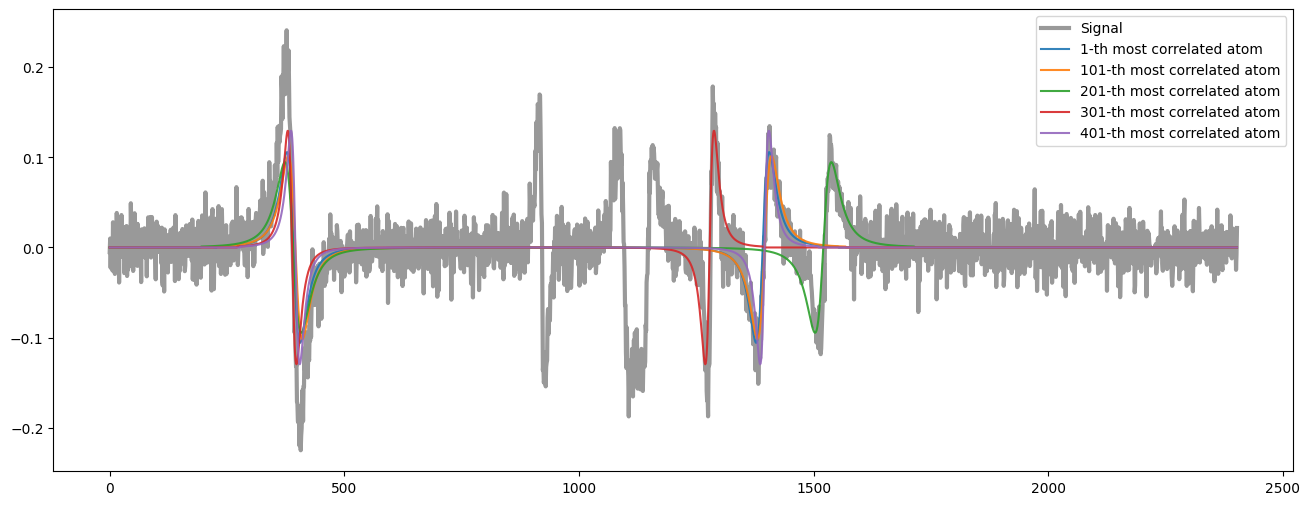

In [77]:
nb_plot = 5
step = len(max_corr_sorted) // nb_plot
# Extract the atoms and their parameters
corr = max_corr_sorted[::step]
idx = max_corr_idx_sorted[::step]
positions = positions_idx[::step]
atoms = atoms_idx[::step]
# Plot the signal and the most correlated atoms
fig, axs = plt.subplots(1, 1, figsize=(16, 6), sharex=True)
axs.plot(signal_dict['signal'], label='Signal', color='k', lw=3, alpha=0.4)

zs_atom0 = dictionary.getAtoms()[atoms_idx[0]]
zs_atom_0_x = positions_idx[0]
s0 = zs_atom0.getAtomInSignal(signal_length=signal_length, offset=zs_atom_0_x)
distAtom0Signal = np.sqrt(1-corr[0]/np.linalg.norm(signal_dict['signal']))

for i, (pos_idx, atom_idx) in enumerate(zip(positions, atoms)) :
        # Get the atom, its signal and its parameters
        zs_atom = dictionary.getAtoms()[atom_idx]
        b, y, s = zs_atom.params['b'], zs_atom.params['y'], zs_atom.params['sigma']
        label = 'ZS-ATOM at x={} : {}'.format(pos_idx, str(zs_atom))
        title = '{}-st most correlated atom with corr={:.3f}'.format(step*i+1, corr[i])
        axs.plot(zs_atom.getAtomInSignal(signal_length=signal_length, offset=pos_idx), label=f'{int(i*step)+1}-th most correlated atom', alpha=0.9)
        atom_signal = zs_atom.getAtomInSignal(signal_length=signal_length, offset=pos_idx)
        
        # Compute the correlation and the distance between the atom and the signal
        corrWithAtom0 = np.correlate(s0, atom_signal, mode='valid')[0]
        distWithAtom0 = np.sqrt(1-np.abs(corrWithAtom0))
        distWithSignal = np.sqrt(1-np.abs(corr[i])/np.linalg.norm(signal_dict['signal']))
        
        print('Correlation rank : {}'.format(int(i*step) + 1))
        print('corr(a, a0) = {:.3f}'.format(corrWithAtom0))
        print('d(a, a0)  = {:.3f}'.format(distWithAtom0))
        print('d(a, s)   = {:.3f}'.format(distWithSignal))
        print('d(a0, s)  = {:.3f}'.format(distAtom0Signal))
        print('>> heuristic = d(a, s) + d(a0, s) = {:.3f}'.format(distAtom0Signal + distWithSignal))
        print('')

axs.legend()
plt.show()

On cherche alors à résoudre le problème d'otpimisation sous contrainte suivant : 
$$
a_1 = \argmax_{a \in \mathbb{D}} \gamma (a, s) \text{  s.c.  } K \leq d(a, s) + d(a_0, s)
$$

In [91]:
def selectivity(bin_mask:np.ndarray) -> float:
    bin_counter = Counter(bin_mask)
    nb_zeros = bin_counter[0]
    return nb_zeros

Max correlation at index 129715 is = 0.5888256919527385
We recover the minimum distance : 0.641


Heuristic to find the new max correlation
Nb zeros = 1638.0
Heursitic max correlation at index 122602 is = 0.4467085995428139


Metric to find the new max correlation
Nb zeros = 455.0
Metric max correlation at index 222691 is = 0.5718914160145044


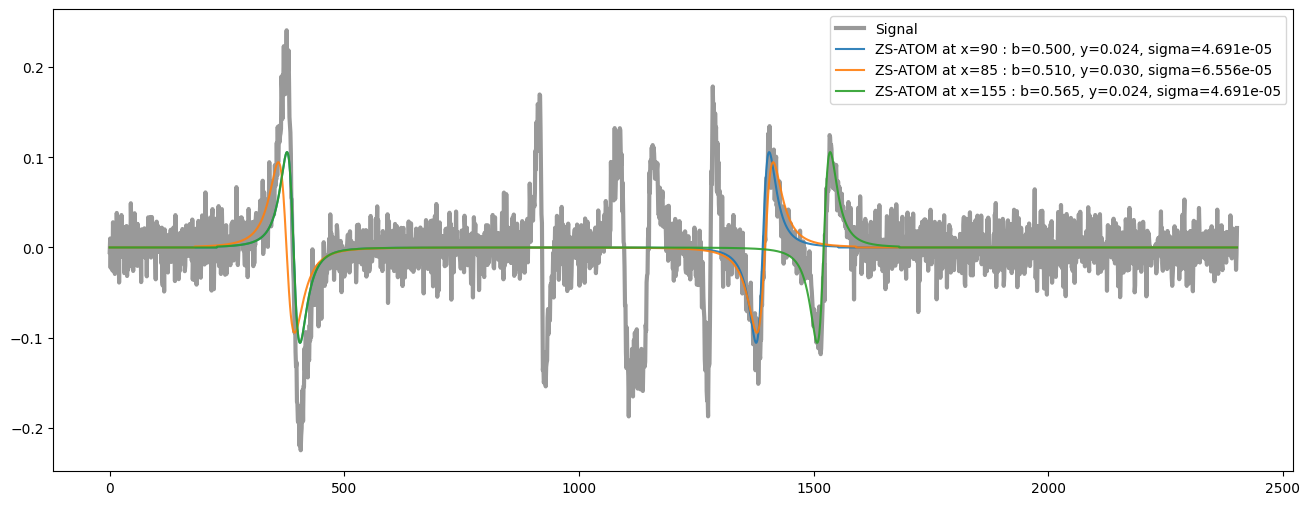

In [99]:
# Compute the correlations and their argmax
all_correlations_signal = dictionary.computeCorrelations(signal_dict['signal'])/np.linalg.norm(signal_dict['signal'])
max_corr_idx = all_correlations_signal.argmax()
max_corr_pos, max_corr_atom = np.unravel_index(max_corr_idx, shape=activation_mask.reshape(-1, nb_atoms).shape)
max_corr_signal = dictionary.getAtoms()[max_corr_atom].getAtomInSignal(signal_length=signal_length, offset=max_corr_pos)
print('Max correlation at index {} is = {}'.format(max_corr_idx, all_correlations_signal.flatten()[max_corr_idx]))

# Compute the distances from the correlations
all_distances_signal = np.sqrt(1-np.abs(all_correlations_signal.flatten()))
min_dist_signal = all_distances_signal.flatten()[max_corr_idx]
print('We recover the minimum distance : {:.3f}'.format(min_dist_signal))

# Compute the heuristic to find the new max correlation
proximity_threshold = 1.08
heuristics = all_distances_signal + min_dist_signal
mask1 = (heuristics >= 2*min_dist_signal*proximity_threshold).astype(int)
masked_correlations = all_correlations_signal.flatten() * mask1
heuristic_max_corr_idx = masked_correlations.argmax()
print('\n\nHeuristic to find the new max correlation')
print('Nb zeros = {:.1f}'.format(selectivity(mask1)))
print('Heursitic max correlation at index {} is = {}'.format(heuristic_max_corr_idx, all_correlations_signal.flatten()[heuristic_max_corr_idx]))

# Compute the metric to find the new max correlation
all_correlations_max_corr = dictionary.computeCorrelations(max_corr_signal)/np.linalg.norm(max_corr_signal)
    #all_distances_max_corr = np.sqrt(1-np.abs(all_correlations_max_corr.flatten()))
similarity_threshold = 0.8
mask2 = (all_correlations_max_corr.flatten() <= similarity_threshold).astype(int)
masked_correlations = all_correlations_signal.flatten() * mask2
metric_max_corr_idx = masked_correlations.argmax()
print('\n\nMetric to find the new max correlation')
print('Nb zeros = {:.1f}'.format(selectivity(mask2)))
print('Metric max correlation at index {} is = {}'.format(metric_max_corr_idx, all_correlations_signal.flatten()[metric_max_corr_idx]))

selected_idx = [max_corr_idx, heuristic_max_corr_idx, metric_max_corr_idx]

# Unravel the index to get the position and the atom
positions_idx, atoms_idx = np.unravel_index(
    selected_idx,
    shape=activation_mask.reshape(-1, nb_atoms).shape,
)

fig, axs = plt.subplots(1, 1, figsize=(16, 6), sharex=True)
axs.plot(signal_dict['signal'], label='Signal', color='k', lw=3, alpha=0.4)
for position_idx, atom_idx in zip(positions_idx, atoms_idx):
    zs_atom = dictionary.getAtoms()[atom_idx]
    label = 'ZS-ATOM at x={} : {}'.format(position_idx, str(zs_atom))
    axs.plot(zs_atom.getAtomInSignal(signal_length=signal_length, offset=position_idx), label=label, alpha=0.9)
axs.legend()
plt.show()

In [65]:
# Compute the distances from the correlations
all_correlations = dictionary.computeCorrelations(signal_dict['signal'])/np.linalg.norm(signal_dict['signal'])
all_distances = np.sqrt(1-np.abs(all_correlations.flatten()))
min_dist_idx = all_distances.argmin()
min_dist = all_distances.flatten()[min_dist_idx]
print('Min distance = {:.3f} at index {}'.format(min_dist, min_dist_idx))

proximity_threshold = 1.1
mask = (all_distances >= proximity_threshold*min_dist).astype(int)
masked_distances = all_distances * mask

print(Counter(mask))

Counter({1: 1144548, 0: 708})
